# Лабораторная работа №1. Регрессия и классификация для табличных данных.


# Подключение kaggle, загрузка датасета, импорт библиотек.

In [210]:
! pip install -q kaggle

In [211]:
! kaggle datasets download -d heptapod/titanic

Dataset URL: https://www.kaggle.com/datasets/heptapod/titanic
License(s): DbCL-1.0
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip '/content/titanic.zip' -d '/content/titanic'

Archive:  /content/titanic.zip
replace /content/titanic/train_and_test2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
CSV_PATH = '/content/titanic/train_and_test2.csv'

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Анализ данных.

In [ ]:
df = pd.read_csv(CSV_PATH)
df.head()

**Описание данных:**
1. PassengerId - ID пассажира
2. Age - Возраст (вещественное)
3. Fare - Стоимость проезда (вещественное)
4. Sex - Пол пассажира (male/female)
5. sibsp - Кол-во родственников (целое)
6. Parch - Кол-во родителей (целое)
7. Pclass - Класс билета (1-3)
8. Embarked - Порт посадки (C/Q/S), C - Cherbourg, Q - Queenstown, S - Southampton
9. Survived - выжил ли пассажир (0/1)

Датасет частично предобратан, а именно:
1. Удалены поля Name, Ticket, что не несут ифнормации;
2. Категориальные строковые данные закодированы;
3. Удален столбец Cabin, содержащий 80%+ пропусков.

In [ ]:
# Удалим не несущее смысла поле ID пассажира.
if 'Passengerid' in df:
  df = df.drop(columns=['Passengerid'])

# Удалим пустые 'zero' признаки.
df = df.loc[:, ~df.columns.str.startswith('zero')]

# Исправим ошибки в названиях столбцов.
df = df.rename(columns={
    '2urvived': 'Survived',
    'sibsp': 'SibSp'
})

# Посмотрим основную информацию о датасете.
print(df.info())
df.describe()

In [ ]:
# Пропущено два значения порта посадки пассажира, заполним модой.
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().index[0])
print(df.info())
df.sample(5, random_state=0)

In [ ]:
# Посмотрим на распределение данных.
def plot_hist(data, **kwargs):
    # Bins и discrete не используется, поскольку они критично замедляют процесс.
    sns.histplot(data=data, kde=True, **kwargs)


g = sns.FacetGrid(pd.melt(df), col='variable', col_wrap=3,
                  sharex=False, sharey=False)
g.map_dataframe(plot_hist)
g.set_titles('{col_name} histogram')
g.set_axis_labels('Value', 'Frequency')
plt.show()

In [ ]:
# Посмотрим на корреляцию признаков.

# Пороговое значения отображения на графике матрицы корреляции (0 - 1)
# Установим порог в 30% корелляции, слабосвязанные признаки нас не интересуют.
THRESHOLD = 0.3  # Установите THRESHOLD = 0 если фильтрация не нужна.

corr_matrix = df.corr()
corr_matrix = corr_matrix.mask(abs(corr_matrix) < THRESHOLD, np.nan)

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
corr_matrix

**Выводы:**
1. Наибольшее влияние на выживаемость влияет пол - большее число мужчин погибло, большее число женщин - выжило;
2. Чем выше класс билета, тем дороже он стоил;
3. Чем больше родственников у пассажира, тем больше братьев/сестер у него;
4. Чем старше пассажир, тем более высокий класс билета у него был.

In [ ]:
target_name = 'Survived'

target = df[target_name]
df = df.drop(target_name, axis=1)

In [ ]:
print(target.value_counts())
print('\nNA count:\n', df.isna().sum(), '\n', sep='')
df.sample(5, random_state=0)

# Подготовка данных

## Импорт библиотек

In [ ]:
! pip install torchinfo --quiet

In [ ]:
! pip install torchsampler==0.1.1 --quiet

In [ ]:
! pip install torchinfo --quiet

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsampler import ImbalancedDatasetSampler as ImbSampler

from sklearn.utils.class_weight import compute_class_weight
from torchinfo import summary

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

## Нормализация, разбиение, тензоры.

In [187]:
# Нормализуем данные.
# Используем RobustScaler, ведь данные содержат выбросы.
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df)

In [188]:
# Распределим данные.
x_train, x_test, y_train, y_test = train_test_split(df_scaled, target, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)
print(
  f'Lengths:\n'
  f'Train = {len(x_train)} ({round(len(x_train)/len(df)*100, 1)}%)\n'
  f' Test = {len(x_test)} ({round(len(x_test)/len(df)*100, 1)}%)\n'
  f'  Val = {len(x_val)} ({round(len(x_val)/len(df)*100, 1)}%)'
)

Lengths:
Train = 1047 (80.0%)
 Test = 131 (10.0%)
  Val = 131 (10.0%)


In [189]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [190]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
      self.data = torch.FloatTensor(data)
      self.targets = torch.FloatTensor(targets)
      self.transform = transform

    def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y

    def __len__(self):
      return len(self.data)

    def get_labels(self):
      return self.targets

In [191]:
train_ds = MyDataset(x_train, y_train.values)
val_ds = MyDataset(x_val, y_val.values)
test_ds = MyDataset(x_test, y_test.values)

In [192]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=False, sampler=ImbSampler(train_ds))
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Модель полносвязного многослойного перцептрона (FFNN) и обучение.

## Модель.

In [193]:
class FFNN_Classificator(nn.Module):
  def __init__(self, num_inputs, num_classes):
      super(FFNN_Classificator, self).__init__()

      __activation = lambda: nn.ReLU(inplace=True)
      self.pipe = nn.Sequential(
          nn.Linear(num_inputs, 48, bias=False),
          __activation(),
          nn.BatchNorm1d(48),

          nn.Linear(48, 32, bias=False),
          __activation(),
          nn.BatchNorm1d(32),

          nn.Linear(32, 16, bias=False),
          __activation(),
          nn.BatchNorm1d(16),

          nn.Linear(16, num_classes)
      )

  def forward(self, x):
      return self.pipe(x)

In [194]:
num_inputs = x_train.shape[1]
num_classes = 2

model = FFNN_Classificator(num_inputs, num_classes)

In [195]:
summary(model, input_size=(num_classes, num_inputs))

Layer (type:depth-idx)                   Output Shape              Param #
FFNN_Classificator                       [2, 2]                    --
├─Sequential: 1-1                        [2, 2]                    --
│    └─Linear: 2-1                       [2, 48]                   336
│    └─ReLU: 2-2                         [2, 48]                   --
│    └─BatchNorm1d: 2-3                  [2, 48]                   96
│    └─Linear: 2-4                       [2, 32]                   1,536
│    └─ReLU: 2-5                         [2, 32]                   --
│    └─BatchNorm1d: 2-6                  [2, 32]                   64
│    └─Linear: 2-7                       [2, 16]                   512
│    └─ReLU: 2-8                         [2, 16]                   --
│    └─BatchNorm1d: 2-9                  [2, 16]                   32
│    └─Linear: 2-10                      [2, 2]                    34
Total params: 2,610
Trainable params: 2,610
Non-trainable params: 0
Total mult-a

In [196]:
# Подсчёт веса классов.
class_weights = compute_class_weight(
  class_weight='balanced', classes=np.array([0, 1]), y=target
)
class_weights = torch.FloatTensor(class_weights).to(device)

In [197]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [198]:
def get_accuracy(predictions, targets):
  classes = torch.argmax(predictions, dim=1)
  correct = (classes == targets).float().sum()
  return correct / len(targets)

In [199]:
def train(model, train_loader, optimizer, criterion, device):
  model.train()
  run_loss = 0.
  run_acc = 0.
  for data in train_loader:
    inputs, targets = data[0].to(device), data[1].to(device).long()
    optimizer.zero_grad()
    predictions = model(inputs)
    loss = criterion(predictions, targets)
    loss.backward()
    optimizer.step()
    run_loss += loss.item()
    run_acc += get_accuracy(predictions, targets)

  train_loss = run_loss / len(train_loader)
  train_acc = run_acc / len(train_loader)
  print(f'     Train avg loss = {train_loss:.4f},'
        f'\tavg acc = {train_acc:.4f}')
  return train_loss, train_acc

In [200]:
def validate(model, val_loader, optimizer, criterion, device):
  model.eval()
  run_loss = 0.
  run_acc = 0.
  with torch.no_grad():
    for data in val_loader:
      inputs, targets = data[0].to(device), data[1].to(device).long()
      predictions = model(inputs)
      loss = criterion(predictions, targets)
      run_loss += loss.item()
      run_acc += get_accuracy(predictions, targets)

  val_loss = run_loss / len(val_loader)
  val_acc = run_acc / len(val_loader)
  print(f'Validation avg loss = {val_loss:.4f},'
        f'\tavg acc = {val_acc:.4f}')
  return val_loss, val_acc

In [201]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [202]:
epochs_num = 100
best_acc = 0.
val_losses, val_accs = [], []
train_losses, train_accs = [], []

early_stopper = EarlyStopper(patience=10, min_delta=0.15)
for epoch in range(1, epochs_num + 1):
  print('\nEpoch:', epoch, end='.\n')
  train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
  val_loss, val_acc = validate(model, val_loader, optimizer, criterion, device)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  val_losses.append(val_loss)
  val_accs.append(val_acc)

  if val_acc > best_acc:
    torch.save(model, 'best-model.pt')
    best_acc = val_acc

  if early_stopper.early_stop(val_losses[-1]):
    break

print('\nBest accuracy:', best_acc)


Epoch: 1.
     Train avg loss = 0.8075,	avg acc = 0.4814
Validation avg loss = 0.7208,	avg acc = 0.6007

Epoch: 2.
     Train avg loss = 0.7580,	avg acc = 0.5196
Validation avg loss = 0.6958,	avg acc = 0.5903

Epoch: 3.
     Train avg loss = 0.7409,	avg acc = 0.5591
Validation avg loss = 0.6762,	avg acc = 0.5486

Epoch: 4.
     Train avg loss = 0.7220,	avg acc = 0.5723
Validation avg loss = 0.6539,	avg acc = 0.5538

Epoch: 5.
     Train avg loss = 0.7080,	avg acc = 0.5910
Validation avg loss = 0.6373,	avg acc = 0.7604

Epoch: 6.
     Train avg loss = 0.7104,	avg acc = 0.5939
Validation avg loss = 0.6296,	avg acc = 0.7812

Epoch: 7.
     Train avg loss = 0.6952,	avg acc = 0.6050
Validation avg loss = 0.6160,	avg acc = 0.7760

Epoch: 8.
     Train avg loss = 0.6839,	avg acc = 0.6523
Validation avg loss = 0.6004,	avg acc = 0.7865

Epoch: 9.
     Train avg loss = 0.6891,	avg acc = 0.6431
Validation avg loss = 0.5925,	avg acc = 0.7969

Epoch: 10.
     Train avg loss = 0.6483,	avg acc = 0.6

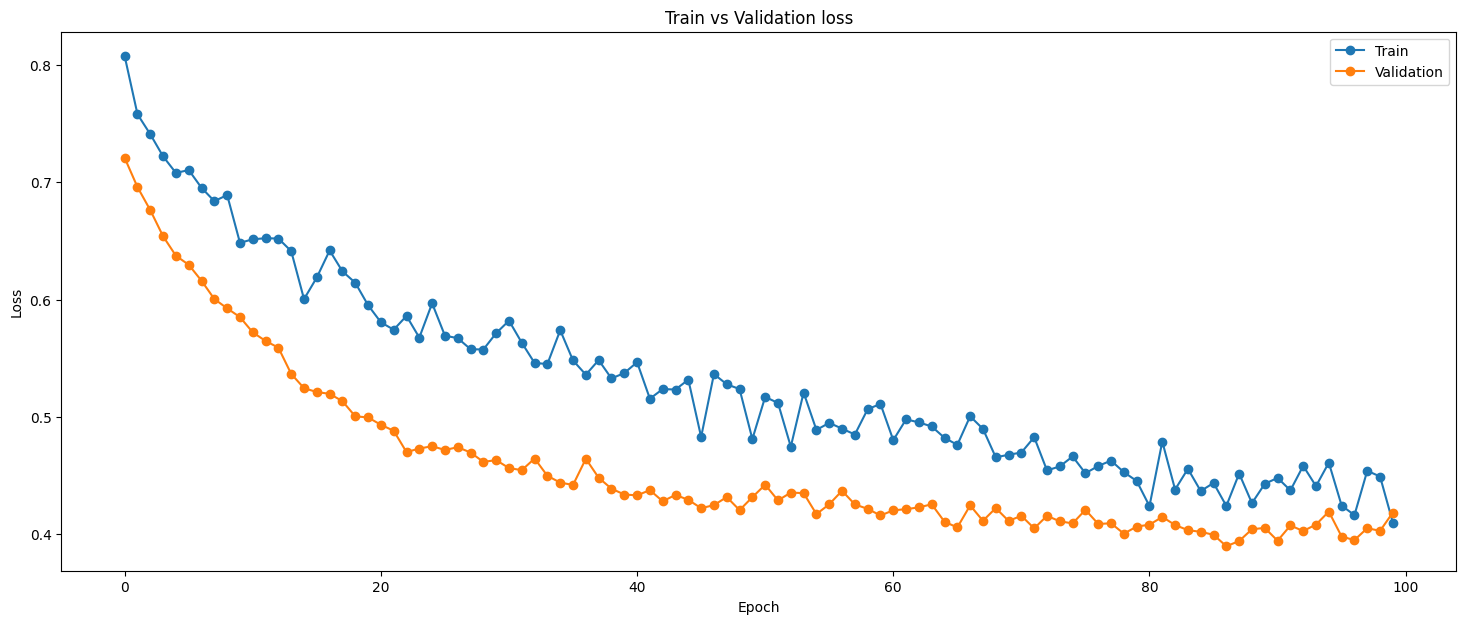

In [203]:
plt.figure(figsize=(18, 7))
plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation loss')
plt.show()

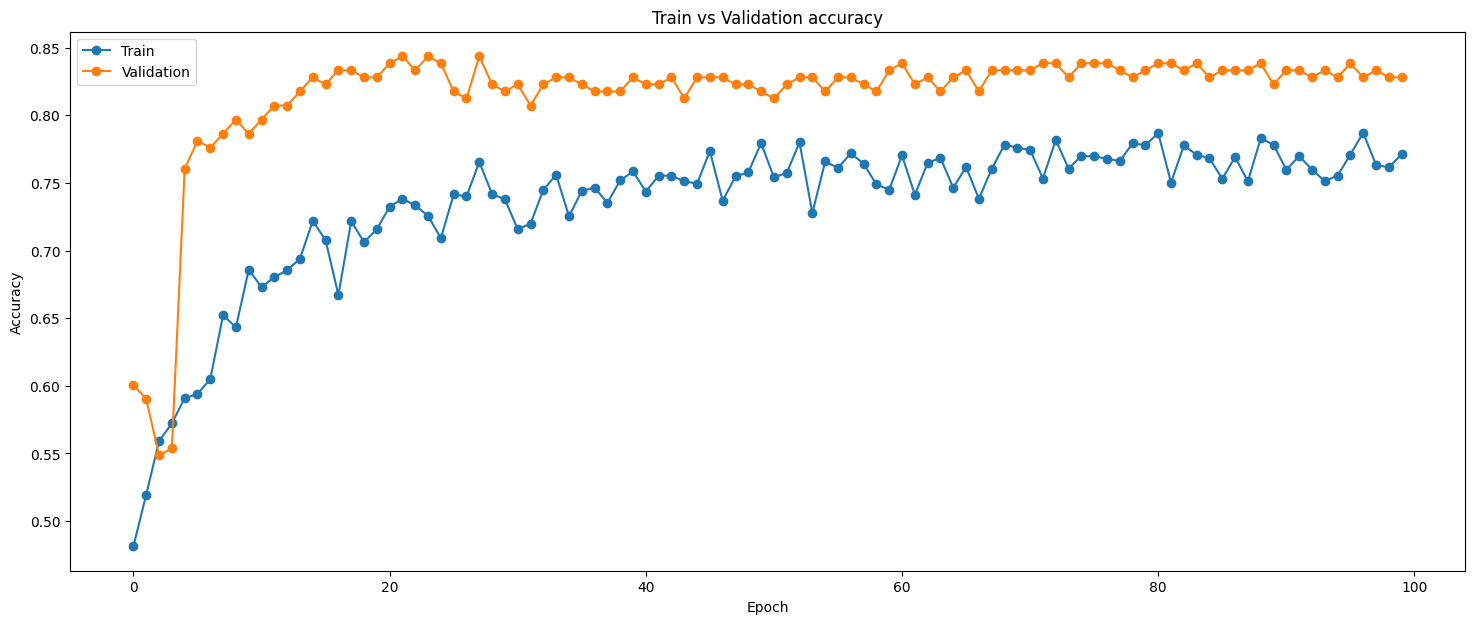

In [204]:
plt.figure(figsize=(18, 7))
plt.plot(train_accs,'-o')
plt.plot(val_accs,'-o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation accuracy')
plt.show()

In [205]:
best_model = torch.load('best-model.pt', weights_only=False)
model.eval()
print('Model loaded.')

Model loaded.


In [206]:
preds = []
trgts = []
with torch.no_grad():
  for data in test_loader:
    inputs, targets = data[0].to(device), data[1].to(device)
    outputs = model(inputs)
    targets = targets.to('cpu').numpy()
    pred = outputs.data.max(1, keepdim=True)[1].to('cpu').numpy()
    trgts.append(targets)
    preds.append(pred)

In [207]:
targets = [x for sub in trgts for x in sub]
predictions = [x[0] for sub in preds for x in sub]
targets = np.array(targets)
predictions = np.array(predictions)

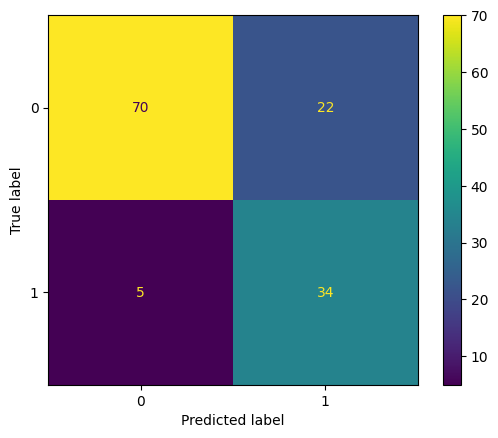

In [208]:
cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm).plot()
plt.show()

In [209]:
f1_score(targets, predictions,average='micro')

0.7938931297709924